In [1]:
import pandas as pd
from urllib.parse import urlparse
import re
import ipaddress

# Load the dataset
df = pd.read_csv('urldata.csv')

# Inspect data
df.sample(100)


,Unnamed: 0,url,label,result
156280,180860,https://www.englize.com/hanna-dvd,benign,0
2122,26702,https://www.edckc.com/,benign,0
5249,29829,https://www.en.wikipedia.org/wiki/Alwyn_Morris,benign,0
38013,62593,https://www.judgepedia.org/index.php/Alvin_Rubin,benign,0
146102,170682,https://www.dailymotion.com/video/x9drss_wcw-s...,benign,0
...,...,...,...,...
414815,439395,http://animatics.co.uk/blog/profile/,malicious,1
393447,418027,http://ccalaabldoeaaalf.info /,malicious,1
253042,277622,https://www.quebeccityhotels.worldweb.com/,benign,0
55515,80095,https://www.newsatellite-tv-forpc.com/sp/3853/,benign,0


In [2]:
# feature extraction preformed by URLFeatureExtraction.py
# python URLFeatureExtraction.py urldata.csv returns featuredata.csv
df = pd.read_csv('featuredata.csv', on_bad_lines='skip')

features = ['Have_IP', 'Have_At', 'URL_Length', 'URL_Depth','Redirection', 
                        'https_Domain', 'TinyURL', 'Prefix/Suffix', 'DNS_Record',
                        'Domain_Age', 'Domain_End', 'iFrame', 'Mouse_Over','Right_Click', 'Web_Forwards']


In [3]:
print(df.head())
print(df.tail())
phishing_count = df[(df['Label'] == 1)].shape[0]
legit_count = df[(df['Label'] == 0)].shape[0]
print(f"phishing: {phishing_count}")
print(f"legit: {legit_count}")

                         URL  Have_IP  Have_At  URL_Length  URL_Depth  \
0         https://www.qq.com        0        0           0        0.0   
1     https://www.amazon.com        0        0           0        0.0   
2     https://www.google.com        0        0           0        0.0   
3  https://www.wikipedia.org        0        0           0        0.0   
4   https://www.facebook.com        0        0           0        0.0   

   Redirection  https_Domain  TinyURL  Prefix/Suffix  DNS_Record  Domain_Age  \
0          0.0           0.0      0.0            0.0         1.0         1.0   
1          0.0           0.0      0.0            0.0         1.0         1.0   
2          0.0           0.0      0.0            0.0         1.0         1.0   
3          0.0           0.0      0.0            0.0         1.0         1.0   
4          0.0           0.0      0.0            0.0         0.0         0.0   

   Domain_End  iFrame  Mouse_Over  Right_Click  Web_Forwards  Label  
0         

## Description of Features

### 1. Have_IP
This checks for an IP address in the URL. This is significant because many phishing links will contain an IP address to mimic a local router, most legit websites use domain names
Example: http://192.168.1.1/login

### 2. Have_At
This checks for the @ symbol in a URL, this is a common phishing technique because the '@' can be used to obscure the actual destination of the link.
Example: http://goodwebsite@malicioussite.com

### 3. URL_Length
This simply checks for the URL length, typically longer URLs are more likely to be malicious links, as the length may obscure where the actual destination of the link is. Our delimeter for length is set to 54

### 4. URL_Depth
This measures how deep a URL goes.
Example: https://facebook.com would have a depth of 0, and https://facebook.com/profiles/myprofile would have a depth of 2

### 5. Redirection
This checks for "//' in a URL outside of after the http or https, which means the user is being redirected, a likely sign of a malicous link
example: http://www.youregonnagetredirected.com//tothisbadsite.com

### 6. https_domain
This checks if the url hides https in its domian name to try and trick an uninformed user to thinking that the sites protocol is https.
Example: http://https-notactuallysecure.com

### 7. Tiny_URL
This checks for a URL shortening service, such as bit.ly. The shortened url still links to the desired webpage, with the actual name of the site being obscured.
Example: bit.ly/3Bg19uM

### 8. Prefix/Suffix
This checks for a prefix or suffix in the domian via looking for a "-". These are rarely used in legit links, yet it adds a feeling of legitimacy to an uninformed user by slightly changing a legit site name.
Example: http://face-book.com

### 9. DNS Record
This checks for the availabilty of the URLs DNS record by checking the WHOIS database. Generally, phishing links' claimed identites are not recognized by the database, or they have no records of their hostname.

### 10. Domain_Age
This checks how long the domain has been going/went. Most phishing sites don't live very long,so the WHOIS database can be used to see when the domain was created and expired. A website living less than 12 months is marked with a 1.

### 11. Domain_End
This checks how long the domain name has been expired by checking the WHOIS database, and comparing the expiry date to the current time. If the URL has been expired for longer than 12 months, it is marked with a 1.

note: there were some issues with connectivity to the whois database, which may lead to false psoitives for the previous 3 categories. This will be looked into.

### 12. iFrame
This checks for iFrame redirection. This is an HTML tag used used to embed a webpage into another, which attackers can use to hide malicous content in sites. This is detected by checking for a response or for iframes in general.

### 13. Mouse_Over
This checks for attackers using javascript to show a fake URL in the status bar to a user. This feature checks for changes in the status bar during the onMouseOver event in the webpage source code

### 14. Right_Click
Attackers can use java script to disable the right clicking function, which would disallow users from seeing the webpage source code. To find this, the webpage source code is searched for event.button==2 to see if right click is disabled.

### 15. Web_Forwards
This checks the number of forwardings, or times a website has been redirected. Generally, a legit link is only forwarded once. In this case we check if the site has been forwarded more than twice before assigning a 1.

In [4]:
# Convert the features into separate columns
# df_features = pd.DataFrame(df['features'].tolist(), index=df.index, columns=features)

# Combine the extracted features with the original DataFrame
# df_combined = pd.concat([df, df_features], axis=1)
df = df.dropna(subset=['Label'])
print(df)


                                                     URL  Have_IP  Have_At  \
0                                     https://www.qq.com        0        0   
1                                 https://www.amazon.com        0        0   
2                                 https://www.google.com        0        0   
3                              https://www.wikipedia.org        0        0   
4                               https://www.facebook.com        0        0   
...                                                  ...      ...      ...   
44366  http://cndoubleegret.com/admin/secure/cmd-logi...        0        0   
44367  http://bexleyphysio.com.au/Excel/login.php?cmd...        0        0   
44368  http://scurit098.atspace.cc/helper-akses/helpr...        0        0   
44369      http://raidfinderpro.com/kazclaw/plugins/adm/        0        0   
44370      http://raidfinderpro.com/xyper/includes/home/        0        0   

       URL_Length  URL_Depth  Redirection  https_Domain  TinyUR

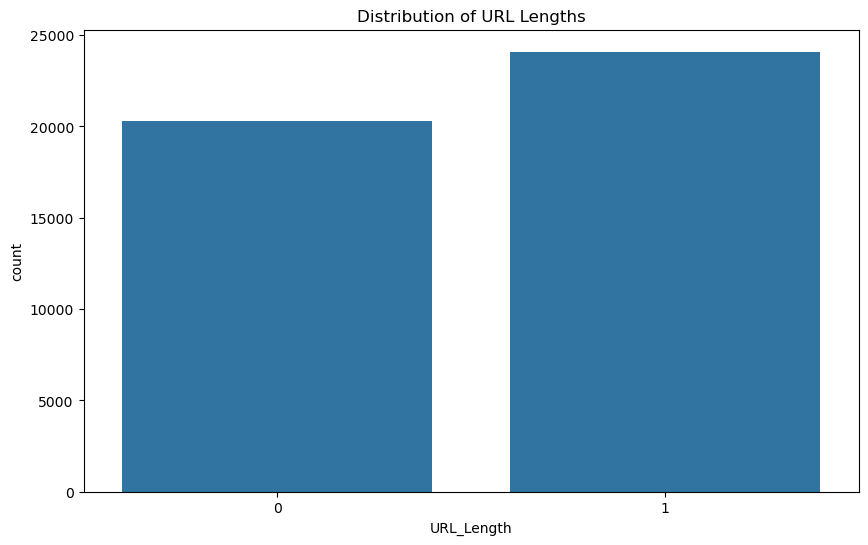

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the figure
plt.figure(figsize=(10, 6))

# Bar plot of URL_Length feature (Not that useful)
# URL_length is set to 1 if a URL is longer than 54 characters, 0 if less
sns.countplot(x='URL_Length', data=df)
plt.title('Distribution of URL Lengths')
plt.show()


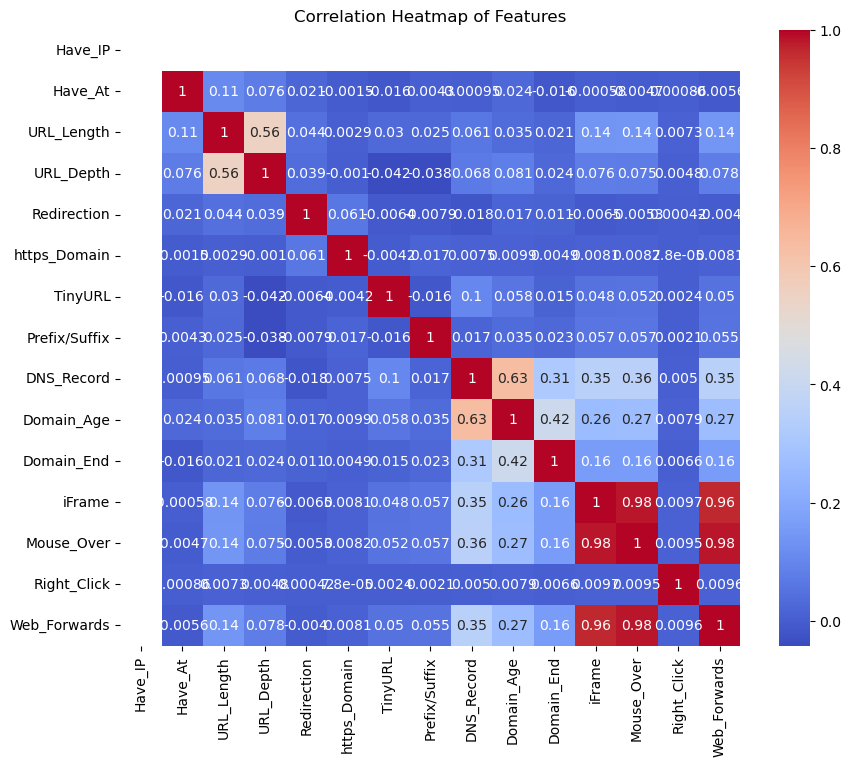

In [6]:
# Create Heatmap for correlations (Also not extremely useful)
# make heatmap for features, first create df without url and label

df_corr = df[features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(df_corr, annot=True, cmap='coolwarm')

plt.title('Correlation Heatmap of Features')
plt.show()

In [7]:
# Check head before scaling
print(df[features].head())


   Have_IP  Have_At  URL_Length  URL_Depth  Redirection  https_Domain  \
0        0        0           0        0.0          0.0           0.0   
1        0        0           0        0.0          0.0           0.0   
2        0        0           0        0.0          0.0           0.0   
3        0        0           0        0.0          0.0           0.0   
4        0        0           0        0.0          0.0           0.0   

   TinyURL  Prefix/Suffix  DNS_Record  Domain_Age  Domain_End  iFrame  \
0      0.0            0.0         1.0         1.0         1.0     0.0   
1      0.0            0.0         1.0         1.0         1.0     0.0   
2      0.0            0.0         1.0         1.0         1.0     0.0   
3      0.0            0.0         1.0         1.0         1.0     0.0   
4      0.0            0.0         0.0         0.0         1.0     0.0   

   Mouse_Over  Right_Click  Web_Forwards  
0         0.0          1.0           0.0  
1         0.0          1.0          

In [8]:
# Print the head URLs and their extracted features
for i in range(5):
    print(f"URL: {df['URL'].iloc[i]}")
    print(f"Extracted features: {df[features].iloc[i]}")


URL: https://www.qq.com
Extracted features: Have_IP          0.0
Have_At          0.0
URL_Length       0.0
URL_Depth        0.0
Redirection      0.0
https_Domain     0.0
TinyURL          0.0
Prefix/Suffix    0.0
DNS_Record       1.0
Domain_Age       1.0
Domain_End       1.0
iFrame           0.0
Mouse_Over       0.0
Right_Click      1.0
Web_Forwards     0.0
Name: 0, dtype: float64
URL: https://www.amazon.com
Extracted features: Have_IP          0.0
Have_At          0.0
URL_Length       0.0
URL_Depth        0.0
Redirection      0.0
https_Domain     0.0
TinyURL          0.0
Prefix/Suffix    0.0
DNS_Record       1.0
Domain_Age       1.0
Domain_End       1.0
iFrame           0.0
Mouse_Over       0.0
Right_Click      1.0
Web_Forwards     0.0
Name: 1, dtype: float64
URL: https://www.google.com
Extracted features: Have_IP          0.0
Have_At          0.0
URL_Length       0.0
URL_Depth        0.0
Redirection      0.0
https_Domain     0.0
TinyURL          0.0
Prefix/Suffix    0.0
DNS_Record    

In [9]:
from sklearn.preprocessing import StandardScaler


# Initialize scaler
scaler = StandardScaler()

# Scale features
df[features] = scaler.fit_transform(df[features])

# Check
print(df[features].head())


   Have_IP   Have_At  URL_Length  URL_Depth  Redirection  https_Domain  \
0      0.0 -0.127986   -1.090177   -1.24169    -0.062749      -0.01163   
1      0.0 -0.127986   -1.090177   -1.24169    -0.062749      -0.01163   
2      0.0 -0.127986   -1.090177   -1.24169    -0.062749      -0.01163   
3      0.0 -0.127986   -1.090177   -1.24169    -0.062749      -0.01163   
4      0.0 -0.127986   -1.090177   -1.24169    -0.062749      -0.01163   

    TinyURL  Prefix/Suffix  DNS_Record  Domain_Age  Domain_End    iFrame  \
0 -0.356835      -0.308833    1.337151    0.848434    0.420242 -1.440608   
1 -0.356835      -0.308833    1.337151    0.848434    0.420242 -1.440608   
2 -0.356835      -0.308833    1.337151    0.848434    0.420242 -1.440608   
3 -0.356835      -0.308833    1.337151    0.848434    0.420242 -1.440608   
4 -0.356835      -0.308833   -0.747859   -1.178642    0.420242 -1.440608   

   Mouse_Over  Right_Click  Web_Forwards  
0   -1.413377     0.006714     -1.437137  
1   -1.41337

In [10]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report


# Define X (features) and y (target)
X = df[features]
y = df['Label']

# Step 1: Perform the train-test split
X_train, X_test_features, y_train, y_test_features = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Use SMOTE to balance the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Step 3: Train the model on the resampled data
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_resampled, y_train_resampled)

# Step 4: Make predictions on the test set
y_pred = rf_model.predict(X_test_features)

# Step 5: Evaluate the model
print("Accuracy:", accuracy_score(y_test_features, y_pred))
print("Classification Report:\n", classification_report(y_test_features, y_pred))


Accuracy: 0.7727938690409106
Classification Report:
               precision    recall  f1-score   support

         0.0       0.79      0.80      0.80      4911
         1.0       0.75      0.74      0.74      3962

    accuracy                           0.77      8873
   macro avg       0.77      0.77      0.77      8873
weighted avg       0.77      0.77      0.77      8873



In [ ]:
# Feature extracted URLs tested on the GRU based RNN
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Step 4: Train the model
history = model.fit(X_train_resampled, y_train_resampled, epochs=5, batch_size=128, validation_data=(X_test_features, y_test_features))

# Step 5: Evaluate the model
loss, accuracy = model.evaluate(X_test_features, y_test_features)
print(f'Test Accuracy: {accuracy}')

c:\Users\tyler\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


NameError: name 'X_test' is not defined

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Concatenate, Input, Embedding, GRU, Dense
from tensorflow.keras.optimizers import Adam

# Step 1: Prepare the data (0 for benign, 1 for phishing)

# Tokenize the URLs (character-level tokenization)
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(df['URL'])

# Convert the URLs into sequences of integers
url_sequences = tokenizer.texts_to_sequences(df['URL'])

# Pad the sequences to make them of equal length
max_sequence_length = 100  # can be adjusted based on data
X = pad_sequences(url_sequences, maxlen=max_sequence_length)

# Target labels
y = df['Label'].values

# Step 2: Train-Test Split
X_train_token, X_test_token, y_train_token, y_test_token = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Build the GRU model
vocab_size = len(tokenizer.word_index) + 1  # Total number of unique characters
embedding_dim = 50  # Size of the character embedding vectors

model = Sequential()

# Embedding layer (convert each character to a dense vector)
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))

# GRU layer
model.add(GRU(128, return_sequences=False))

# Output layer (binary classification)
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Step 4: Train the model
model.fit(X_train_token, y_train_token, epochs=5, batch_size=128, validation_data=(X_test_token, y_test_token))

# Step 5: Evaluate the model
loss, accuracy = model.evaluate(X_test_token, y_test_token)
print(f'Test Accuracy: {accuracy}')


Epoch 1/5


c:\Users\tyler\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


278/278 ━━━━━━━━━━━━━━━━━━━━ 48s 155ms/step - accuracy: 0.7864 - loss: 0.4254 - val_accuracy: 0.9453 - val_loss: 0.1611
Epoch 2/5
278/278 ━━━━━━━━━━━━━━━━━━━━ 42s 150ms/step - accuracy: 0.9777 - loss: 0.0806 - val_accuracy: 0.9923 - val_loss: 0.0312
Epoch 3/5
278/278 ━━━━━━━━━━━━━━━━━━━━ 42s 151ms/step - accuracy: 0.9924 - loss: 0.0282 - val_accuracy: 0.9937 - val_loss: 0.0273
Epoch 4/5
278/278 ━━━━━━━━━━━━━━━━━━━━ 41s 146ms/step - accuracy: 0.9932 - loss: 0.0240 - val_accuracy: 0.9940 - val_loss: 0.0251
Epoch 5/5
278/278 ━━━━━━━━━━━━━━━━━━━━ 40s 145ms/step - accuracy: 0.9929 - loss: 0.0230 - val_accuracy: 0.9922 - val_loss: 0.0282
278/278 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.9933 - loss: 0.0249
Test Accuracy: 0.9922236204147339


In [ ]:
# concatonate tokenized URL and feature 
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 50

url_input = Input(shape=(max_sequence_length,), name="url_input")
model_input = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length)(url_input)
model_input = GRU(128)(model_input)

feature_input = Input(shape=(X_train_resampled.shape[1],), name="feature_input")

# Concatenate GRU output with the additional feature vector
model_input = Concatenate()([model, feature_input])

model_input = Dense(64, activaion='relu')(model_input)
model_input = Dropout(0.5)(model_input)
output = Dense(1, activation='sigmoid')(model_input)

model = Model(inputs=[url_input, feature_input], outputs=output)




In [ ]:
# Save the trained GRU model
model.save('phishing_gru_model.keras')

# Save the tokenizer using pickle
import pickle

with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)


In [ ]:
# Import required modules
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle

# Load the saved GRU model in .keras format
model = load_model('phishing_gru_model.keras')

# Example usage: Tokenizing a new URL
MAX_SEQUENCE_LENGTH = 100  # Same value used during training

In [ ]:
from sklearn.metrics import roc_curve

# Example: Get prediction probabilities for a test dataset
y_prob = model.predict(X_test_token).flatten()

# Compute ROC curve and find the optimal threshold
fpr, tpr, thresholds = roc_curve(y_test_token, y_prob)
optimal_idx = (tpr - fpr).argmax()  # Maximize TPR - FPR
optimal_threshold = thresholds[optimal_idx]

print(f"Optimal Threshold: {optimal_threshold}")

# Use the new threshold in predictions
prediction = 'phishing' if y_prob[0] >= optimal_threshold else 'benign'
print(f"Prediction: {prediction} , {y_prob[0]}")


278/278 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step
Optimal Threshold: 0.33115461468696594
Prediction: benign , 0.0006800182163715363


In [ ]:
from imblearn.over_sampling import SMOTE

# Resample the training set using SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


In [ ]:
from sklearn.metrics import classification_report

y_pred = (y_prob >= optimal_threshold).astype(int)
print(classification_report(y_test_token, y_pred))


              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      4911
         1.0       0.99      0.99      0.99      3962

    accuracy                           0.99      8873
   macro avg       0.99      0.99      0.99      8873
weighted avg       0.99      0.99      0.99      8873



In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense

# Example GRU model
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=50, input_length=100))  # Embedding Layer
model.add(GRU(128, return_sequences=False))  # GRU Layer
model.add(Dense(1, activation='sigmoid'))  # Output Layer

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


c:\Users\tyler\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Example URL
url = "http://gemmell.co.nz/view/"

# Tokenize the URL
sequence = tokenizer.texts_to_sequences([url])

# Pad the sequence to match the input length (100 in this case)
padded_sequence = pad_sequences(sequence, maxlen=100)

# Check the shape
print(padded_sequence.shape)  # Should be (1, 100)



(1, 100)


In [ ]:
import numpy as np

# Expand the dimensions to make it (1, 100, 1)
input_data = np.expand_dims(padded_sequence, axis=-1)

# Check the shape
print(input_data.shape)  # Should be (1, 100, 1)


(1, 100, 1)


In [ ]:
# Retrain the model with the corrected input
history = model.fit(X_train, y_train, epochs=2, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy}")

# Example prediction
prediction = model.predict(input_data)[0][0]
result = 'phishing' if prediction >= 0.5 else 'benign'
print(f"Prediction: {result}, Probability: {prediction}")


Epoch 1/2
1110/1110 ━━━━━━━━━━━━━━━━━━━━ 73s 62ms/step - accuracy: 0.8783 - loss: 0.2653 - val_accuracy: 0.9914 - val_loss: 0.0337
Epoch 2/2
1110/1110 ━━━━━━━━━━━━━━━━━━━━ 68s 61ms/step - accuracy: 0.9914 - loss: 0.0319 - val_accuracy: 0.9918 - val_loss: 0.0319
278/278 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9929 - loss: 0.0281
Test Accuracy: 0.9917727708816528
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step
Prediction: phishing, Probability: 0.9994447231292725


In [ ]:
# Imports (Place all necessary imports at the top)
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle

# Load the trained model
model = load_model('phishing_gru_model.keras')

# Load the tokenizer
with open('tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)

# Define a function to predict a single URL
def predict_single_url(url, model, tokenizer, max_length=100):
    """Predict if a URL is phishing or benign using the trained GRU model."""
    # Tokenize and pad the sequence
    sequence = tokenizer.texts_to_sequences([url])
    padded_sequence = pad_sequences(sequence, maxlen=max_length)

    # Predict using the model
    prediction = model.predict(padded_sequence)[0][0]

    # Classify based on a threshold
    result = 'phishing' if prediction >= 0.5 else 'benign'

    # Display the result
    print(f"URL: {url} | Prediction: {result} | Probability: {prediction:.4f}")

# Example usage
print("Testing a single URL prediction:")
predict_single_url("http://gemmell.co.nz/view/", model, tokenizer)

# Optional: Test multiple URLs
def predict_multiple_urls(urls, model, tokenizer, max_length=100):
    """Predict phishing or benign for multiple URLs."""
    for url in urls:
        predict_single_url(url, model, tokenizer, max_length)

# Example with multiple URLs
urls_to_test = [
    "http://gemmell.co.nz/view/",
    "https://www.google.com",
    "http://fake-phish.com"
]
print("\nTesting multiple URLs:")
predict_multiple_urls(urls_to_test, model, tokenizer)



Testing a single URL prediction:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step
URL: http://gemmell.co.nz/view/ | Prediction: phishing | Probability: 0.9996

Testing multiple URLs:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
URL: http://gemmell.co.nz/view/ | Prediction: phishing | Probability: 0.9996
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
URL: https://www.google.com | Prediction: benign | Probability: 0.0017
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
URL: http://fake-phish.com | Prediction: phishing | Probability: 0.9986
